In [41]:
import mlflow

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import xgboost as xgb

### Data

In [42]:
x_train = "data/processed/bank_train.csv"
x_test = "data/processed/bank_test.csv"
x_val = "data/processed/bank_val.csv"

x_train_data = pd.read_csv(x_train)
x_test_data = pd.read_csv(x_test)
x_val_data = pd.read_csv(x_val)

x_train_data.drop(x_train_data.columns[0], axis=1, inplace=True)
x_test_data.drop(x_test_data.columns[0], axis=1, inplace=True)
x_val_data.drop(x_val_data.columns[0], axis=1, inplace=True)

In [43]:
y_train = "data/processed/bank_train_labels.csv"
y_test = "data/processed/bank_test_labels.csv"
y_val = "data/processed/bank_val_labels.csv"

y_train_data = pd.read_csv(y_train)
y_test_data = pd.read_csv(y_test)
y_val_data = pd.read_csv(y_val)

y_train_data.drop(y_train_data.columns[0], axis=1, inplace=True)
y_test_data.drop(y_test_data.columns[0], axis=1, inplace=True)
y_val_data.drop(y_val_data.columns[0], axis=1, inplace=True)

### Combining Test and Validation datasets

In [44]:
x_test = pd.concat([x_test_data, x_val_data], ignore_index=True)
y_test = pd.concat([y_test_data, y_val_data], ignore_index=True)

In [45]:
label_counts = np.bincount(y_train_data["target"])

print("Train Data")
print("Total Data Points: ", len(y_train_data))
print(f"Marketing Successful: {label_counts[1]}")
print(f"Marketing Failed: {label_counts[0]}")

label_counts = np.bincount(y_test["target"])

print("\nTest Data")
print("Total Data Points: ", len(y_test))
print(f"Marketing Successful: {label_counts[1]}")
print(f"Marketing Failed: {label_counts[0]}")



Train Data
Total Data Points:  30742
Marketing Successful: 3609
Marketing Failed: 27133

Test Data
Total Data Points:  14469
Marketing Successful: 1680
Marketing Failed: 12789


### Merging the Features and Labels for splitting the Train data into Positive Label sized chunks

In [46]:
train_data = pd.concat([x_train_data, y_train_data], axis=1)

In [47]:
label_0_index = train_data[train_data['target'] == 0].index
label_1_index = train_data[train_data['target'] == 1].index

#### Negative Samples: 27k
#### Positive Samples: 3.6k

#### Ratio: 7.5

In [48]:
label_0_splits = np.array_split(label_0_index, 7)

In [49]:
for idx in range(len(label_0_splits)):
    print(f"Negative Label Sample {idx} Count: ", len(label_0_splits[idx]))

Negative Label Sample 0 Count:  3877
Negative Label Sample 1 Count:  3876
Negative Label Sample 2 Count:  3876
Negative Label Sample 3 Count:  3876
Negative Label Sample 4 Count:  3876
Negative Label Sample 5 Count:  3876
Negative Label Sample 6 Count:  3876


### Creating 7 new dataframes with balanced positive and negative labels

In [50]:
label_0_train_dataframes = [train_data.loc[indices].copy() for indices in label_0_splits]
label_1_df = train_data.loc[label_1_index].copy()

In [51]:
train_dataframes = []

for i in range(len(label_0_train_dataframes)):
    train_dataframes.append(pd.concat([label_0_train_dataframes[i], label_1_df], axis=0))
    train_dataframes[i] = train_dataframes[i].sample(frac=1).reset_index(drop=True)

type(train_dataframes[0])

pandas.core.frame.DataFrame

### Training Model


### Estimators

In [52]:
svm_clf_linear = SVC(C=34, kernel='linear')
svm_clf_rbf = SVC(C=34)
svm_clf_poly = SVC(C=25, kernel='poly', degree=3, gamma=0.01)

### Training Multiple Models

In [53]:
classifiers = []
histories = []

for clf_idx in range(len(train_dataframes)):
    x_train_data = train_dataframes[clf_idx].drop(labels="target", axis = 1)
    y_train_data = train_dataframes[clf_idx]['target']

    classifiers.append(svm_clf_poly)
    histories.append(classifiers[clf_idx].fit(x_train_data, y_train_data))

    print(f"{clf_idx + 1} Model[s] Trained")

1 Model[s] Trained
2 Model[s] Trained
3 Model[s] Trained
4 Model[s] Trained
5 Model[s] Trained
6 Model[s] Trained
7 Model[s] Trained


### Generating Multiple 7 Sets of Predictions for the Test Data

In [54]:
y_preds = [each_clf.predict(x_test) for each_clf in classifiers]

### Getting the final Prediction using Max Vote Count

In [55]:
final_preds = []

for row_idx in range(len(x_test)):

    predictions = [y_preds[clf_idx][row_idx] for clf_idx in range(len(y_preds))]

    element_counts = Counter(predictions)
    max_prediction = max(element_counts, key=element_counts.get)

    final_preds.append(int(max_prediction))

### Metrics

#### Confusion Matrix

In [58]:
confusionMatrix = confusion_matrix(y_test, final_preds)
confusionMatrixNorm = confusion_matrix(y_test, final_preds, normalize='pred')

fig, axes = plt.subplots(1,2, figsize=(11,4))

sns.heatmap(confusionMatrix, annot=True, ax=axes[0], cmap='YlGnBu', fmt="d")
axes[0].set_title("Confusion Matrix")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

sns.heatmap(confusionMatrixNorm, annot=True, cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Normalized Predictions")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.show()

#### Classification Report

In [59]:
target_names = ['Unsuccessful', 'Successful']
print(classification_report(y_test, final_preds, target_names=target_names))

### SVC Linear

#### Confusion Matrix

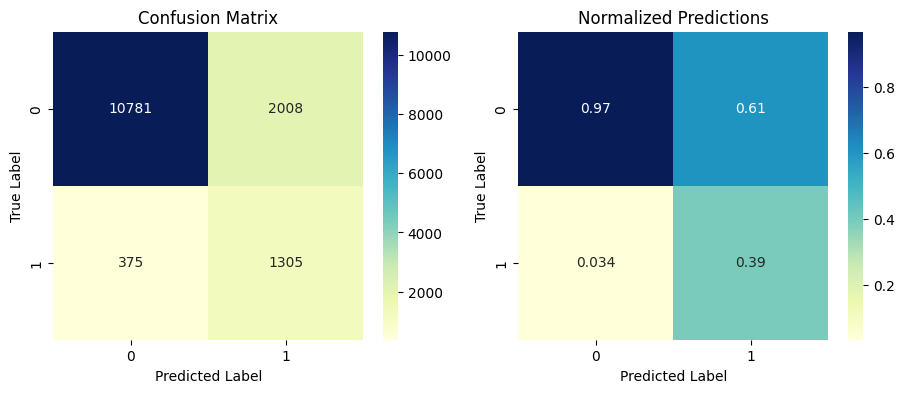

#### Classification Report

              precision    recall  f1-score   support

Unsuccessful       0.97      0.84      0.90     12789
  Successful       0.39      0.78      0.52      1680

    accuracy                           0.84     14469
   macro avg       0.68      0.81      0.71     14469
weighted avg       0.90      0.84      0.86     14469



### SVC RBF

#### Confusion Matrix

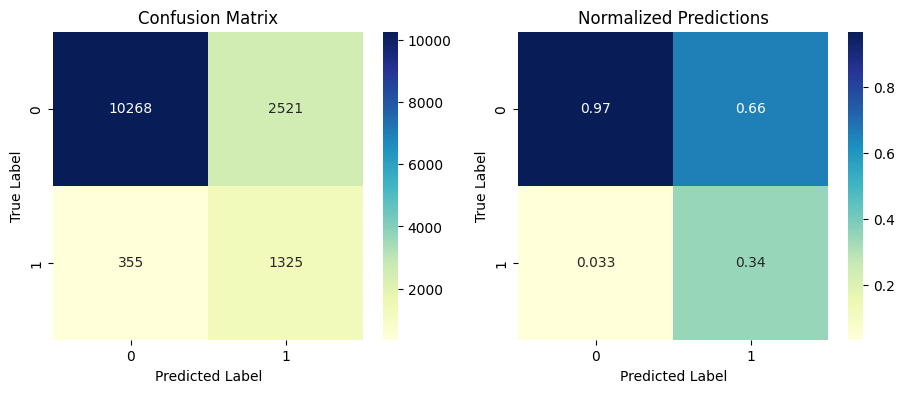

#### Classification Report

              precision    recall  f1-score   support

Unsuccessful       0.97      0.80      0.88     12789
  Successful       0.34      0.79      0.48      1680

    accuracy                           0.80     14469
   macro avg       0.66      0.80      0.68     14469
weighted avg       0.89      0.80      0.83     14469



### SVC Poly

#### Confusion Matrix

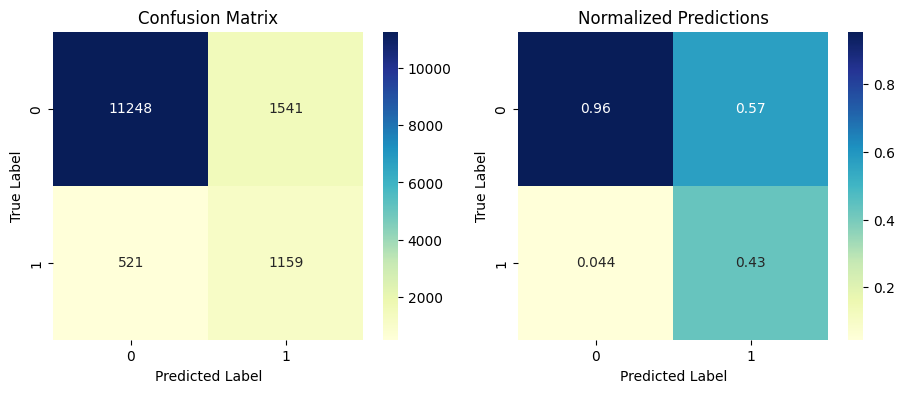

#### Classification Report

              precision    recall  f1-score   support

Unsuccessful       0.96      0.88      0.92     12789
  Successful       0.43      0.69      0.53      1680

    accuracy                           0.86     14469
   macro avg       0.69      0.78      0.72     14469
weighted avg       0.89      0.86      0.87     14469

